# Обучение с учителем

Алгоритмы, которые требуют размеченной выборки для обучения, называются алгоритмами обучения с учителем. "Разметить выборку" означает поставить в соответствие объекту обучающей выборки значение целевой переменной (таргета) которое алгоритм машинного обучения  должен "выучить"

Обычно большие объёмы дорого размечать - можно пользоваться сервисами типа "Яндекс.Толока", либо своими силами размечать.

# Классификация

## Постановка задачи классификации

Классификация - задача для алгоритмов машинного обучения восстановить на объектах обучающей выборки **метки классов**. Классы - конечный (дискретный) набор целевых переменных. Например, в задаче фильтрации спама два класса: спам (метка $1$) и не спам (метка $0$)

Существует бинарная классификация (когда классов всего два: $0$ и $1$) и мультиклассовая классификация, когда классов несколько. Если научились классифицировать на два класса, то и на несколько получиться: метод One vs All


Продемострируем работу алгоритма классификации на данных по оттоку, которые содержатся в файле `data/client_segmentation.csv`. В файле содержится информация по клиентам оператора связи о том, как изменилось потребление услуг оператора за два месяца:
* call_diff доля звонков
* sms_diff доля смс
* доля интернет-трафика traffic_diff

Все показатели вычисляются по формуле

$$
\frac{\text{new_value}-\text{old_value}}{\text{old_value}}
$$

В последней колонке `customes_class` содержится метка по оттоку:
* $0$ - активный пользователя
* $1$ - "спящий" пользователь (редко пользуется услугами)
* $2$ - пользователь, который ушел в отток

In [42]:
import os
import sys

import numpy as np

run_env = os.getenv('RUN_ENV', 'COLLAB')
if run_env == 'COLLAB':
  from google.colab import drive
  ROOT_DIR = '/content/drive'
  drive.mount(ROOT_DIR)
  print('Google drive connected')
  root_data_dir = os.path.join(ROOT_DIR, 'MyDrive', 'ml_course_data')
  sys.path.append(os.path.join(ROOT_DIR, 'MyDrive', 'src'))
else:
  root_data_dir = os.getenv('DATA_DIR', '/srv/data')

print(os.listdir(root_data_dir))

if not os.path.exists(root_data_dir):
  raise RuntimeError('Data dir not exists')
else:
  print('Data dir content %s: %s' % (root_data_dir, ', '.join(os.listdir(root_data_dir))))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google drive connected
['nyt-ingredients-snapshot-2015.csv', 'insurance (1).csv', 'non_linear.csv', 'client_segmentation.csv', 'eigen.pkl', 'clustering.pkl', 'boosting_toy_dataset.csv', 'politic_meme.jpg', 'gray_goose.jpg', 'test_dataset.pkl', 'memes', 'optimal_push_time', 'sklearn_data', 'my_little_recsys', 'corpora', 'logs', 'nltk_data', 'recsys_data', 'MNIST', 'hymenoptera_data', 'pet_projects', 'ocr_dataset_sample.csv', 'geo_points.csv.gzip', 'scored_corpus.csv', 'labeled_data_corpus.csv', 'memes_stat_dataset.zip', 'als_model.pkl', 'raw_data.zip', 'json_views.tar.gz', 'test_data.csv', 'sales_timeseries_dataset.csv.gz', 'brand_tweets_valid.csv', 'brand_tweets.csv', 'Health_and_Personal_Care.jsonl.gz', 'models', 'final_dataset.zip', 'ocr_dataset.zip', 'bidmachine_logs.zip', 'meta_Health_and_Personal_Care.jsonl.gz', 'messages.db', 'user_item_views.zip', 'con

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

%matplotlib inline
np.set_printoptions(precision=4)

file_path = os.path.join(root_data_dir, 'client_segmentation.csv')
df_source = pd.read_csv(
    file_path,
    dtype={'call_diff': np.float32, 'call_diff': np.float32, 'traffic_diff': np.float32, 'customes_class': np.uint16}
)
X = df_source[['call_diff','sms_diff','traffic_diff']].values
y = df_source.customes_class.values

df_source.head(5)

,call_diff,sms_diff,traffic_diff,customes_class
0,-0.666421,0.444911,-0.273538,0
1,-0.889273,-0.537896,-1.959469,2
2,-0.841503,0.846665,0.727606,0
3,1.389749,0.390911,1.789246,1
4,-1.228211,-1.375899,-1.434209,2


<Axes: >

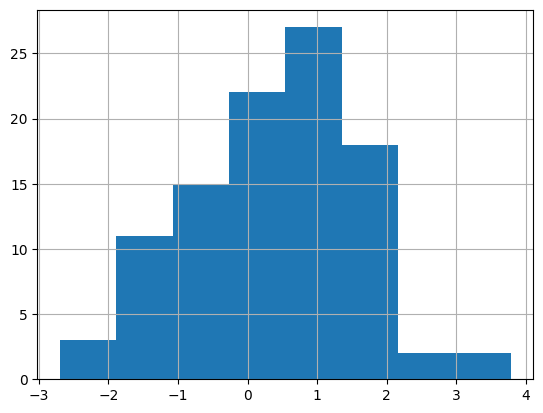

In [44]:
df_source.sms_diff.hist(bins=8)

In [45]:
df_source.customes_class.value_counts()

,count
customes_class,
0,34
2,33
1,33


Построим наивный байесовский классификатор - этот алгоритм в дополнительных материалах к курсу, его обучение основано на подсчете вероятностей классов относительно фичей.

Оценим качество классификатора: сколько пользователей предсказали правильно

In [46]:
from sklearn.naive_bayes import GaussianNB

naive_bayes = GaussianNB() # создаём экземпляр класса
naive_bayes.fit(X, y) # обучение модели
predicted_classes = naive_bayes.predict(X) # предсказание (эксплуатация модели)

accuracy = (predicted_classes == y).sum() / len(y)

print(f'Точность предсказаний: {accuracy}')

Точность предсказаний: 0.95


Можно вытащить, например, априорные вероятности классов

In [47]:
print(naive_bayes.class_prior_)

[0.34 0.33 0.33]


## Алгоритмы классификации

Алгоритмы приводятся в виде ссылок на документацию sklearn

### [Наивный Байесовский классификатор](https://scikit-learn.org/stable/modules/naive_bayes.html)

Классификатор основан на вероятностном подходе: подсчёт частот встречаемости фичей.

Очень просто реализовать, поэтому работает достаточно быстро. Применим  на больших объёмах данных в случае, когда количество фичей не очень большое.

### [Метод $K$ ближайших соседей](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)

Т.н. "ленивый" (lazy algorithm) алгоритм классификации, который работает за два шага:

* запоминает объекты обучающей выборки и их классы
* в момент предсказания для объекта находит $k$ самых близких объектов из обучающей выборки и присваивает новому объекту класс большинства его "соседей"



### [Логистическая регрессия](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression)

Алгоритм, основанный на идеях линейной регрессии. Применим для бинарной классификации, на выходе выдаёт вероятность того, что объект принадлежит классу $1$, которая вычисляется по формуле

$$
P(y==1 | x) = \frac{1}{1+e^{z}}
$$

Где $z$ - линейная комбинация фичей объекта
$$
z = \theta^T x = \theta_1 x_1 + \theta_2 x_2 + \ldots + \theta_n x_n
$$

Обучение сводится к вычислению оптимального набора $\theta = [\theta_1, \theta_2, \ldots, \theta_n]$

Статья [пережёвываем логистическую регрессию](https://m.habr.com/ru/post/485872/)_


**Примечание**: другой пример линейного классификатора - [машина опорных векторов](https://scikit-learn.org/stable/modules/svm.html#classification)

В этом алгоритме мы обучаем вектор весов $W$ таким образом, чтобы прямая $y=W^TX$, задаваемая этими весами, проходила на максимальном удалении от точек обоих классов

![svm_hyperplane.png](img/svm_hyperplane.png)

Отличная [статья на Хабре про SVM](https://habr.com/ru/company/ods/blog/484148/)


### [Дерево принятия решений]()

Дерево принятия решений в задачах классификации можно представить как последовательность вопросов о фичах объекта, которая приводит к однозначному определению класса объекта. Каждый следующий вопрос зависит от того, какой ответ был получен на предыдущем шаге

Как каждый такой вопрос - это проверка признака по некоторому "порогу разбиения" и разбиение выборки на две части по этому порогу. Порог разбиения выбирается таким образом, чтобы минимизировать энтропию (т.е. уменьшить неопределенность) в двух получившихся частях выборки.

Более подробно ( в т.ч. про энтропию) можно почитать в [Статье от ODS](https://habr.com/ru/company/ods/blog/322534)

In [48]:
from sklearn import tree

clf = tree.DecisionTreeClassifier().fit(X, y)

Предсказания одного дерева получаем по формуле

In [49]:
predicted_classes = clf.predict(X)

accuracy = (predicted_classes == y).sum() / len(y)

print(f'Точность предсказаний: {accuracy}')

Точность предсказаний: 1.0


Визуализация дерева принятия решений

[Text(0.5909090909090909, 0.9, 'x[0] <= 0.259\ngini = 0.667\nsamples = 100\nvalue = [34, 33, 33]'),
 Text(0.36363636363636365, 0.7, 'x[1] <= 0.629\ngini = 0.528\nsamples = 68\nvalue = [33, 2, 33]'),
 Text(0.4772727272727273, 0.8, 'True  '),
 Text(0.18181818181818182, 0.5, 'x[2] <= -0.411\ngini = 0.26\nsamples = 39\nvalue = [6, 0, 33]'),
 Text(0.09090909090909091, 0.3, 'gini = 0.0\nsamples = 26\nvalue = [0, 0, 26]'),
 Text(0.2727272727272727, 0.3, 'x[1] <= -0.702\ngini = 0.497\nsamples = 13\nvalue = [6, 0, 7]'),
 Text(0.18181818181818182, 0.1, 'gini = 0.0\nsamples = 7\nvalue = [0, 0, 7]'),
 Text(0.36363636363636365, 0.1, 'gini = 0.0\nsamples = 6\nvalue = [6, 0, 0]'),
 Text(0.5454545454545454, 0.5, 'x[0] <= -0.32\ngini = 0.128\nsamples = 29\nvalue = [27, 2, 0]'),
 Text(0.45454545454545453, 0.3, 'gini = 0.0\nsamples = 27\nvalue = [27, 0, 0]'),
 Text(0.6363636363636364, 0.3, 'gini = 0.0\nsamples = 2\nvalue = [0, 2, 0]'),
 Text(0.8181818181818182, 0.7, 'x[1] <= -0.899\ngini = 0.061\nsamples

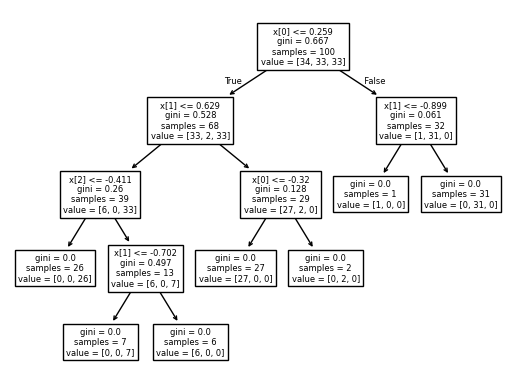

In [50]:
%matplotlib inline

tree.plot_tree(clf)

### [Классификатор на случайных деревьях](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier)

Строим большое количество случайных деревьев, а итоговое предсказание - результат "голосования" деревьев

![random_forest_introduction.jpg](img/random_forest_introduction.jpg)


Почему это работает?

Если у каждого дерева вероятность правильного предсказания выше, чем 0.5 то у чем больше таких деревьев тем выше вероятнсть правильного ответа

## Метрики классификации

Все метрики классификации основаны на следующей таблице, которая содержит возможные исходы работы классификатора: ошибочные и корректные.

![confusion_matrix.png](img/confusion_matrix.png)

В таблице 4 исхода применения классификатора:

* `true positive`: класс $1$ предсказали правильно
* `false positive`: класс $1$ предсказали неправильно
* `true negative`: класс $0$ предсказали правильно
* `false negative`: класс $0$ предсказали неправильно

На числах, которые находятся в ячейках таблицы можно построить огромное количество метрик

Видим, что у нас примерно одинакоково представлены все классы. Ситуация, когда один класс представлен слишком сильно и ли наоборот слишком слабо в выборке называется "дисбаланс классов".

Есть два основных приёма решения проблемы дисбаланса
* undersampling доминирующего класса
* oversampling класса с меньшим числом элементов

Важный момент: дальше мы будем решать задачу классификации на 2 класса

Для этого искусственно разделим класс `2` между классами `0` и `1`


In [51]:
# сводим задачу к бинарной классификации
df_source = pd.read_csv(
    file_path,
    dtype={'call_diff': np.float32, 'call_diff': np.float32, 'traffic_diff': np.float32, 'customes_class': np.uint16}
)
df_source[(df_source.customes_class==2) & (df_source.call_diff>1.1)] = 0
df_source[(df_source.customes_class==2) & (df_source.call_diff<=1.1)] = 1

df_source.head()

,call_diff,sms_diff,traffic_diff,customes_class
0,-0.666421,0.444911,-0.273538,0
1,1.000000,1.000000,1.000000,1
2,-0.841503,0.846665,0.727606,0
3,1.389749,0.390911,1.789246,1
4,1.000000,1.000000,1.000000,1


Для начала посчитаем собственно confusion matrix

Кoличество объектов в тестовой выборке: 33


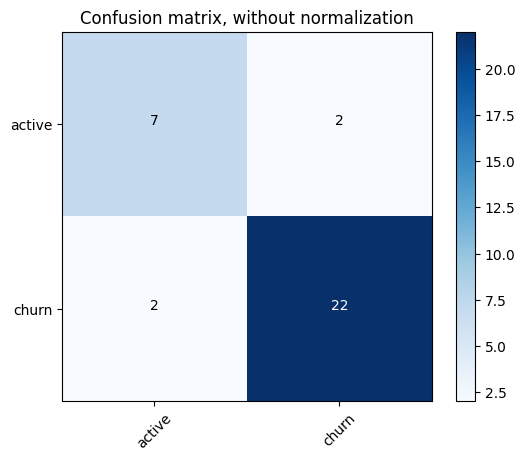

In [52]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools


X = df_source[['call_diff','sms_diff','traffic_diff']].values
y = df_source.customes_class.values

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
naive_bayes.fit(X_train, y_train)
y_pred = naive_bayes.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(
    conf_matrix,
    classes=['active', 'churn'],
    title='Confusion matrix, without normalization'
)
print(f'Кoличество объектов в тестовой выборке: {len(y_pred)}')

Активно используются следующие метрики

**Accuracy**

$$
\frac{TP + TN}{TP + TN + FP + FN}
$$

**Precision**
$$
\frac{TP}{TP + FP}
$$

**Recall**
$$
\frac{TP}{TP + FN}
$$

**F1-score**
$$
2\frac{precision\cdot recall}{precision + recall}
$$

**Logistic Loss**
$$
-\frac{1}{l}\sum_{i=1}^{l}\left(y_i \log\hat{y}_i + (1-y_i) \log(1-\hat{y}_i)\right)
$$


Про метрики есть хороший разбор на хабре [в статье про метрики](https://habr.com/ru/company/ods/blog/328372/)

In [53]:
from sklearn.metrics import accuracy_score, log_loss, f1_score, precision_score, recall_score

for f in [accuracy_score, log_loss, f1_score, precision_score, recall_score]:
    print(f'{f.__name__}:\t{f(y_test, y_pred)}')

accuracy_score:	0.8787878787878788
log_loss:	4.368927683529352
f1_score:	0.9166666666666666
precision_score:	0.9166666666666666
recall_score:	0.9166666666666666


# Naive Bayes implementation

Попробуем для решения задачи использовать классификатор "из коробки": воспользуемся  [наивным Байесовским классификатором](https://scikit-learn.org/stable/modules/naive_bayes.html). Кстати, реализация содержит функцию `.partial_fit()` с которой мы уже встречались! Вспомните где именно.

Этот классификатор основан на частотах встречаемости фичей. У нас фичи непрерывные, так что вместо частот будем использовать вероятности.

Классификатор очень быстро обучается, т.к. по сути нам нужно просто посчитать разные статистики по выборке - никакого градиентного спуска тут нет.

Пусть $c$ - класс объекта (у нас три класса) тогда мы берём объект и предсказываем вероятности по формуле Байеса для всех трёх классов, а класс объекту присваиваем тот, у которого максимальная вероятность - это называется Maximum a posteriori (MAP) estimation, метод максимальной апостериорной вероятност (потому что формула Байеса для вычисляет апостериорную вероятност гипотезы)

$$
c_{MAP} = \arg \max_{\substack{c \in C}}P(c \mid X) = \arg \max_{\substack{c \in C}}\frac{P(c)P(X\mid c)}{P(X)}
$$

В формуле
* P(c) - вероятность класса, его встречаемость
* P(X|c) - вероятность встретить объект с конкретными фичами в конкретном классе, то есть насколько объект объект ожидаем встретить в классе $c$
* P(X) - распределение данных. Т.к. мы ищем максимум по всем $c$, а знаменатель от C не зависит, то его вообще можно не учитывать

Для начала вычислим априорные вероятности классов $P(c)$

In [54]:
from collections import Counter

num_samples = df_source.shape[0]  # число объектов
prior_class_counts = Counter(y)  # группируем по классу и считаем колияество объектов каждого класса
prior_class_probs = dict() # тут будем хранить  априорные вероятности классов
print(prior_class_counts)
for class_label in prior_class_counts:
  prior_class_probs[class_label] = prior_class_counts[class_label] / num_samples
print(prior_class_probs)

Counter({np.uint16(1): 66, np.uint16(0): 34})
{np.uint16(0): 0.34, np.uint16(1): 0.66}


Как посчитать $P(X\mid c)$? Каждый объект $x \in X$ состоит из фичей, это вектор $x = [x_1, \ldots, n_n ]$, в нашем случае это из три элементов (у нас три фичи). Классификатор называется *наивным*, потому что мы делаем предположение о независимости фичей - в этом случае совместное распределение можно расписать через произведение маргинальных распределений

$$
P(X\mid c) = P(x_1\ldots x_n\mid c) = P(x_1 \mid c)\cdot \ldots \cdot P(x_n\mid c) = \prod_{i=1}^nP(x_i\mid c)
$$

Небольшое преобразование: т.к. ищем максимум то можем применить логарифм чтобы перейти от произведения к сумме (т.к. логарифм фозрастающая функция и на точку максимума не вилияет

$$
\ln P(X\mid c) = \ln\prod_{i=1}^nP(x_i\mid c) = \sum_{i=1}^n\log P(x_i\mid c)
$$

Как для конкретной фичи $x_i$ найти $P(x_i\mid c)$? Для непрерывной фичи придётся ввести предположение о том, что фича имеет гауссовское распределение, то есть

$$
P(x_i\mid c) = \frac{1}{\sqrt{2\pi \sigma^2_{x|c}}}\exp\left(-\frac{(x - \mu_{x|c})^2}{2\sigma^2_{x|c}}\right)
$$

Где $\sigma_{x|c}$ - СКО фичи $x$ для класса $c$, $\mu_{x|c}$ - МО фичи $x$ для класса $c$. Это параметры гауссовского распределения - их мы оценим по выборке.

Алгоритм оценки параметров следующий:
* берём класс $c$
* оставляем в датасете только примеры этого класса $c$
* вычисляем $\sigma_{x|c}$ и $\mu_{x|c}$

В результате получим словарь, где ключ - имя фичи, а значение - вложенный словарь, где ключ - метка класса, а значение - параметры гауссовского распределения фичи этом классе, то есть получаем структуру вида
```python
{
  class_1: {mu: some_value, sigma: some_value},
  class_2: {mu: some_value, sigma: some_value},
  class_3: {mu: some_value, sigma: some_value}
}
```

Работать будем с `pandas.DataFrame` чтобы упростить фильтрацию и подсчёт статистик

In [55]:
from collections import defaultdict

target_col = 'customes_class'
feature_names = ['call_diff','sms_diff','traffic_diff']

feature_proba_param = defaultdict(dict)
for col in feature_names:  # цикл по фичам
  for class_id in prior_class_probs:  # цикл по классам
    feature_values = df_source[df_source[target_col]==class_id][col]  # отфильтруем фичу по классу
    feature_proba_param[col][class_id] = {
        'mu': feature_values.mean(),
        'sigma': feature_values.std()
    }
# посмотрим распределение статистике по конкретной фиче
feature_example = 'call_diff'
print(feature_example)
feature_proba_param[feature_example]

call_diff


{np.uint16(0): {'mu': np.float32(-1.0015249), 'sigma': 0.7415683269500732},
 np.uint16(1): {'mu': np.float32(1.1297727), 'sigma': 0.44200706481933594}}

По сути мы нашли  параметры распределения - можем посчитать вероятности классов

Теперь можем построить алгоритм предсказания с помощью MAP
* для объекта $x$ считаем $P(c_1 | X), P(c_2 | X), P(c_3 | X)$
* выбираем максимальную вероятность - это и будет наше предсказание

время познакомится с библиотекой [scipy](https://docs.scipy.org/) - оттуда возьмём реализацию $P(X | c)$ для [распределения гаусса](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html)

In [59]:
from scipy.stats import norm


def eval_bayes(row):
  log_classes_probas = defaultdict(float)  # т.к. нужно собирать сумму из разных фичей
  for feature in feature_names:
    feature_params = feature_proba_param[feature]  # извлекаем параметры распределения фичи (там три класса)
    for class_id in feature_params:  # считаем априорную вероятность получить такое значение фичи в каждом классе
      feature_class_params = feature_params[class_id]  # достаём параметры распределения (mu, sigma), которые посчитали на предыдущем шаге
      feature_class_proba = norm.pdf(
          row[feature],
          loc=feature_class_params['mu'], scale=feature_class_params['sigma']
      )
      # вероятность в интервале [0, 1] - там отрицательные значения логарифма
      log_classes_probas[class_id] += np.log(feature_class_proba)
  sorted_log_classes_probas = sorted(log_classes_probas.items(), key = lambda x: x[1], reverse=True)
  predicted_class, predicted_class_proba = sorted_log_classes_probas[0]
  return predicted_class, predicted_class_proba

def predict(input_df):
  res = []
  for _, row in input_df.iterrows():
    class_label, _ = eval_bayes(row)
    res.append(class_label)
  return res

def predict_proba(input_df):
  res = []
  for _, row in input_df.iterrows():
    _, class_proba = eval_bayes(row)
    res.append(class_proba)
  return res

# predict_proba(df_source[feature_names].head(1))
predicted_classes = predict(df_source[feature_names])
accuracy = (predicted_classes == y).sum() / len(y)
print('Предсказания построены, accuracy = %.2f' % accuracy)

Предсказания построены, accuracy = 0.96


Проверим точность классификатора в реализации sklearn

In [60]:
from sklearn.naive_bayes import GaussianNB

naive_bayes = GaussianNB() # создаём экземпляр класса
naive_bayes.fit(X, y) # обучение модели
predicted_classes = naive_bayes.predict(X) # предсказание (эксплуатация модели)

accuracy = (predicted_classes == y).sum() / len(y)

print('Предсказания построены, accuracy = %.2f' % accuracy)

Предсказания построены, accuracy = 0.97


Визуализируем confusion matrix

Кoличество объектов в тестовой выборке: 33


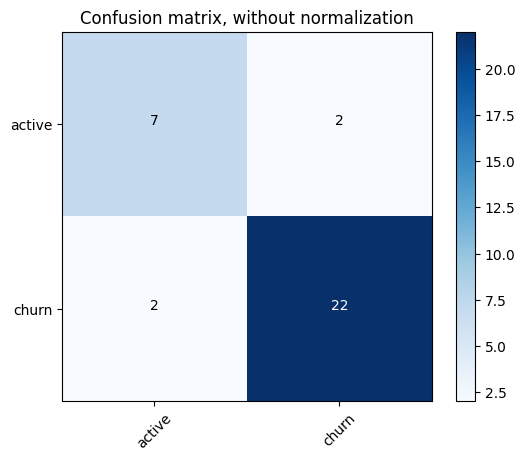

In [61]:
from matplotlib import pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools

# сводим задачу к бинарной классификации
# df_source = pd.read_csv(
#     'data/client_segmentation.csv',
#     dtype={'call_diff': np.float32, 'call_diff': np.float32, 'traffic_diff': np.float32, 'customes_class': np.uint16}
# )

X = df_source[['call_diff','sms_diff','traffic_diff']].values
y = df_source.customes_class.values

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
naive_bayes.fit(X_train, y_train)
y_pred = naive_bayes.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(
    conf_matrix,
    classes=['active', 'churn'],
    title='Confusion matrix, without normalization'
)
print(f'Кoличество объектов в тестовой выборке: {len(y_pred)}')

Самостоятельное задание: постройте бейзлайн в виде рандомного предсказания классов, вероятность класса $1$ возьмите такую же, как в исходном датасете

In [62]:
# --------- ВАШ КОД ТУТ --------





# --------------------------------

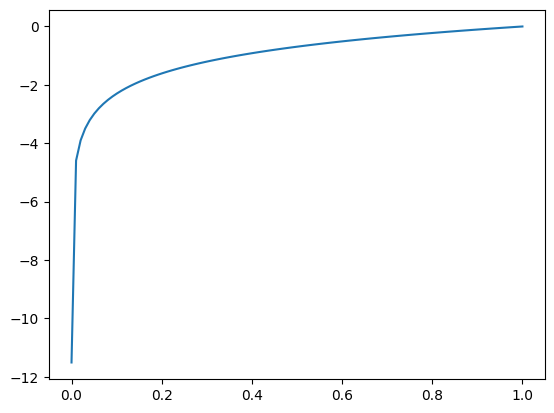

In [63]:
import numpy as np
from matplotlib import pyplot as plt
x_space = np.linspace(0.00001, 1, num=100)
plt.plot(x_space, np.log(x_space))

# Logistic regression

Другой интересный классификатор, для обучения которого уже применим градиентнй спуск - это логистическая регрессия

Для понимания логистической регресси представим что у нас есть задача бинарной классификации, где два класса: класс $1$ (успех) и класс $0$ (неуспех), вероятность успеха обозначим $p$

Шансы на успех (odds) - это отношение числа успехов  к числу неуспехов

$$
odds = \frac{p}{1-p}
$$

В отличие от вероятности эта величина может быть как меньше единицы (если вероятность успеха меньше $0.5$) так и больше единицы (если вероятность успеха больше $0.5$). Термин шировко применяется в ставкав: допустим, мы выиграли в 15 играх из 100: в этом случае шансы на успех всего $\frac{15}{85}=\frac{3}{17}=0.17$ c другой стороны, если выиграть 60 игр из 100 то шансы на успех уже $\frac{60}{40}=\frac{3}{2}=1.5$



Теперь проведем небольшьшой трюк и логарифмируем наши шансы на успех

$$
\log odds = \log \frac{p}{1-p}
$$

График логарифма мы строили ранее в этом семинаре: для значений от $0$ до $1$ получим отрицательные значения, выше - положительные

Мы знаем, что линейная регрессия $\hat{y} = w_0x_0 + \ldots w_nx_n$ "умеет" предсказывать величины от $-\infty$ до $\infty$. Получается, мы по данным $X$ хотим предсказывать шансы на успех (как в ставках на спорт), например для конкретного объекта x у которого $n$ фичей:

$$
w_0x_0 + \ldots w_nx_n = \overline{w}x = \log \frac{p}{1-p}
$$

Превращаем логарифм в экспоненту
$$
\exp(\overline{w}x) = \frac{p}{1-p}
$$

И окончательно выражаем вероятность успеха $p$ для конкретного объекта $x_i$:
$$
p_i = \frac{1}{1+e^{-\overline{w}x_i}}
$$

Функция $\sigma (z) = \frac{1}{1+e^{-z}}$ называеся *сигмоидой* - в курсе по нейросетям с сигмоидой вы встретитесь ещё не раз. Она обладает рядом интересных свойств, например $\sigma (-z) = 1 - \sigma (z)$

Дальше нужно подобрать оптимальные веса $w$. В задаче линейной регресси эмирический риск $Q_{\text{emp}}$ мы считали как сумму квадратов отклонений предикта от таргета. Тут мы аналогично алгоритму наивного байеса воспользуемся достижениями из тервера и выпишем *правдоподобие данных* для выборки из распределения Бернулли (т.к. $y_i=0$ либо $y_i=1$ ) размера $N$:
$$
P(y | X, w) = \prod_{i}^N p^{y_i}(1-p)^{1-y_i}
$$
Чтобы избавиться от произведения переходим к логарифмам (т.к. нам нужно найти точку максимума и логарифмирование на эту точку всё равно не повлияет)
$$
\log P(y | X, w) = \sum_{i}^{N} y_i \log p_i + (1-y_i)\log(1-p_i)
$$

Т.к. $p=\sigma (z)$ и $\sigma (-z) = 1 - \sigma (z)$ то окончательно получаем
$$
\log P(y | X, w) = \sum_{i}^{N} y_i \log \sigma (z) + (1-y_i)\log(\sigma (-z))
$$

Правдоподобие нужно *максимизировать*, тогда функционал эмпирического риска, который мы минимизируем:
$$
L(y, X, w) = - \sum_{i}^{N} y_i \log \sigma (z) + (1-y_i)\log(\sigma (-z))
$$

Кстати, такая функция потерь называется "бинарная кросс-энтропия" или *BCE (binary crossemtropy loss)*. Аналитическое решение тут уже нельзя найти, зато отлично будет работать градиентный спуск, нужно только найти градиент функции потерь $L(Y, X, w)$

$$
\nabla L = \frac{1}{N}\left(Y - \hat{Y}\right)\cdot X
$$

Здесь $X$ - матрица объекты-признаки, а $\hat{Y} = \sigma(\overline{w}x)$.одробнее про вывод этой формулы можно почитать в разделе про [логиcтическую регрессию](https://ml-handbook.ru/chapters/linear_models/intro) - только там не совсем правильно, т.к. нет усреднения ошибки.

Можем реализовать на python (вот [тут](https://towardsdatascience.com/logistic-regression-from-scratch-in-python-ec66603592e2) подробнее и с картинками). Для начала сигмоиду

In [64]:
def sigmoid(z):
  return 1 / ( 1. + np.exp(-z))

x = np.array([1, 2, 3, 5])
sigmoid(x)

array([0.7311, 0.8808, 0.9526, 0.9933])

Далее собственно градиентный спуск

In [73]:
from scipy.spatial import distance
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def gradient(X, y, w, alpha=0) -> np.array:
    """Вычисляем градиент в точке"""
    # количество обучающих примеров в выборке
    n = X.shape[0]
    # считаем прогноз
    y_hat = sigmoid(X.dot(w.T))
    # вычисляем ошибку прогноза
    error = (y - y_hat).reshape(1, -1)
    # дальше pointwise перемножение - умножаем каждую из координат на ошибку
    grad = (-1.) * error.dot(X) / n
    return grad, error

def eval_w_next(X, y, eta, w_current):
    """Делаем шаг градиентного спуска"""
    # вычисляем градиент
    grad, error = gradient(X, y, w_current)
    # делаем шаг градиентного спуска
    w_next = w_current - eta*grad
    # print(w_next.shape, w_current.shape)
    # проверяем условие сходимости
    weight_evolution = distance.euclidean(w_current.flatten(), w_next.flatten())
    return (w_next, weight_evolution, grad)

Повторяем шаги до сходимости

In [74]:
def gradient_descent(X: np.array, y: np.array, eta=0.01, epsilon=0.001) -> np.array:
    m = X.shape[1] # количество фичей
    # инициализируем рандомом веса
    w = np.random.random(m).reshape(1, -1)
    w_next, weight_evolution, grad = eval_w_next(X, y, eta, w)
    step = 0
    # повторяем до сходимости вектора весов
    while weight_evolution > epsilon:
        w = w_next
        w_next, weight_evolution, grad = eval_w_next(X, y, eta, w)
        step += 1
        if step % 100 == 0:
            print("step %s |w-w_next|=%.5f, grad=%s" % (step, weight_evolution, grad))
    return w

# добавляем тривиальный признак w_0, столбец из единиц. См. прошлый урок, почему так
X_extended = np.hstack([
    np.ones(X.shape[0]).reshape(-1,1),
    X
])
print(X_extended.shape)
w = gradient_descent(
    X_extended,
    y.reshape(-1, 1),
    eta=0.008
)

(100, 4)
step 100 |w-w_next|=0.00369, grad=[[ 0.1709 -0.3218  0.176   0.2223]]
step 200 |w-w_next|=0.00287, grad=[[ 0.1182 -0.2739  0.1149  0.1625]]
step 300 |w-w_next|=0.00221, grad=[[ 0.0779 -0.2304  0.0665  0.1128]]
step 400 |w-w_next|=0.00177, grad=[[ 0.0522 -0.197   0.0351  0.0799]]
step 500 |w-w_next|=0.00149, grad=[[ 0.0368 -0.1718  0.0159  0.0598]]
step 600 |w-w_next|=0.00130, grad=[[ 0.0275 -0.1523  0.0041  0.0475]]
step 700 |w-w_next|=0.00115, grad=[[ 0.0219 -0.1367 -0.0033  0.0397]]
step 800 |w-w_next|=0.00104, grad=[[ 0.0183 -0.124  -0.0081  0.0347]]


In [75]:
def predict(X, w):
  y_probas = sigmoid(X.dot(w.T))
  y_hat = np.zeros_like(y_probas)
  y_hat[np.where(y_probas >= 0.5)] = 1
  y_hat[np.where(y_probas < 0.5)] = 0
  y_hat = y_hat.flatten().astype(np.uint16)

  return y_hat

predicted_classes = predict(X_extended, w)
accuracy = (predicted_classes == y).sum() / len(y)
print('Предсказания построены, accuracy = %.2f' % accuracy)

Предсказания построены, accuracy = 0.97


Сраваним с "коробочной" реализацией

In [76]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression().fit(X, y)

predicted_classes = log_reg.predict(X)
accuracy = (predicted_classes == y).sum() / len(y)
print('Предсказания построены, accuracy = %.2f' % accuracy)

Предсказания построены, accuracy = 0.99
